# Introduction

# Libraries and Modules

In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import itertools

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("GnBu_d")

import os, shutil
import cv2
import pytesseract
from PIL import Image
from scipy import ndimage
import swifter
from IPython.display import Image
import pydotplus
import pickle

from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Label
import ipywidgets as widgets

In [14]:
import tensorflow as tf
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics.pairwise import pairwise_distances
from keras import models

Using TensorFlow backend.


## Py files

In [83]:
import preprocess as pre
# import images
import recommendation as reco
%reload_ext autoreload
%autoreload 2

In [3]:
!pwd

/Users/valmadrid/DataScienceBootcamp/Projects/Final Project/Predicting-PetFinder-Adoption-Rate


# Pre-processing

## Data Fields

* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to breed_labels.csv)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to breed_labels.csv
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to color_labels.csv)
* Color2 - Color 2 of pet (Refer to color_labels.csv)
* Color3 - Color 3 of pet (Refer to color_labels.csv)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to state_labels.csv)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
* PetID - Unique hash ID of pet profile
* PhotoAmt - Total uploaded photos for this pet
* AdoptionSpeed - Categorical speed of adoption:
    - 0 - Pet was adopted on the same day as it was listed.
    - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
    - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
    - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
    - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [74]:
pets = pd.read_csv("pets.csv")
pets.dropna(axis=0, subset=["filename"], inplace=True)
pets.fillna("", inplace=True)
pets.reset_index(drop=True, inplace=True)
pets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14652 entries, 0 to 14651
Data columns (total 35 columns):
adoption_speed              14652 non-null int64
pet_id                      14652 non-null object
type                        14652 non-null int64
name                        14652 non-null object
age                         14652 non-null int64
breed1                      14652 non-null int64
breed1_desc                 14652 non-null object
breed2                      14652 non-null int64
breed2_desc                 14652 non-null object
gender                      14652 non-null int64
color1                      14652 non-null int64
color1_desc                 14652 non-null object
color2                      14652 non-null int64
color2_desc                 14652 non-null object
color3                      14652 non-null int64
color3_desc                 14652 non-null object
maturity_size               14652 non-null int64
fur_length                  14652 non-null int64
va

In [75]:
pets.replace({"gender": {1: "Male", 2:"Female", 3:"Mixed (>1 pets)"}}, inplace=True)
pets.replace({"maturity_size": {1: "Small", 2:"Medium", 3:"Large",  4:"ExtraLarge", 0:"Not Specified"}}, inplace=True)
pets.replace({"fur_length": {1: "Short", 2:"Medium", 3:"Long",  0:"Not Specified"}}, inplace=True)
pets.replace({"vaccinated": {1: "Yes", 2:"No", 0:"Not Sure"}}, inplace=True)
pets.replace({"dewormed": {1: "Yes", 2:"No", 0:"Not Sure"}}, inplace=True)
pets.replace({"sterilized": {1: "Yes", 2:"No", 0:"Not Sure"}}, inplace=True)
pets.replace({"health": {1: "Healthy", 2:"Minor Injury", 3:"Serious Injury",  0:"Not Specified"}}, inplace=True)
# pickle.dump(pets, open("pets_reco.pkl", "wb"))
pets.head()

,adoption_speed,pet_id,type,name,age,breed1,breed1_desc,breed2,breed2_desc,gender,color1,color1_desc,color2,color2_desc,color3,color3_desc,maturity_size,fur_length,vaccinated,dewormed,sterilized,health,quantity,fee,state,state_desc,rescuer_id,video_count,photo_count,filename,description,desc_score,desc_magnitude,desc_sentences_score_sum,desc_sentences_score_avg
0,2,86e1089a3,2,Nibble,3,299,tabby,0,,Male,1,black,7,white,0,,Small,Short,No,No,No,Healthy,1,100,41326,selangor,8480853f516546f6cf33aa88cd76c379,0,1.0,86e1089a3-1.jpg,Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.,0.3,2.4,1.8,0.3
1,0,6296e909a,2,No Name Yet,1,265,domestic_medium_hair,0,,Male,1,black,2,brown,0,,Medium,Medium,3,3,3,Healthy,1,0,41401,kuala_lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,2.0,6296e909a-1.jpg,I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.,-0.2,0.7,-0.5,-0.25
2,3,3422e4906,1,Brisco,1,307,mixed_breed,0,,Male,2,brown,7,white,0,,Medium,Medium,Yes,Yes,No,Healthy,1,0,41326,selangor,fa90fa5b1ee11c86938398b60abc32cb,0,7.0,3422e4906-3.jpg,"Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.",0.2,3.7,1.4,0.2
3,2,5842f1ff5,1,Miko,4,307,mixed_breed,0,,Female,1,black,2,brown,0,,Medium,Short,Yes,Yes,No,Healthy,1,150,41401,kuala_lumpur,9238e4f44c71a75282e62f7136c6b240,0,8.0,5842f1ff5-1.jpg,"Good guard dog, very alert, active, obedience waiting for her good master, plz call or sms for more details if you really get interested, thanks!!",0.9,0.9,0.9,0.9
4,2,850a43f90,1,Hunter,1,307,mixed_breed,0,,Male,1,black,0,,0,,Medium,Short,No,No,No,Healthy,1,0,41326,selangor,95481e953f8aed9ec3d16fc4509537e8,0,3.0,850a43f90-1.jpg,"This handsome yet cute boy is up for adoption. He is the most playful pal we've seen in our puppies. He loves to nibble on shoelaces , Chase you at such a young age. Imagine what a cute brat he will be when he grows. We are looking for a loving home for Hunter , one that will take care of him and give him the love that he needs. Please call urgently if you would like to adopt this cutie.",0.6,3.7,3.5,0.583333


In [77]:
pets.columns

Index(['adoption_speed', 'pet_id', 'type', 'name', 'age', 'breed1',
       'breed1_desc', 'breed2', 'breed2_desc', 'gender', 'color1',
       'color1_desc', 'color2', 'color2_desc', 'color3', 'color3_desc',
       'maturity_size', 'fur_length', 'vaccinated', 'dewormed', 'sterilized',
       'health', 'quantity', 'fee', 'state', 'state_desc', 'rescuer_id',
       'video_count', 'photo_count', 'filename', 'description', 'desc_score',
       'desc_magnitude', 'desc_sentences_score_sum',
       'desc_sentences_score_avg'],
      dtype='object')

In [76]:
dogs = pets.query("type==1")
cats = pets.query("type==2")
# pickle.dump(dogs, open("df_dogs.pkl", "wb"))
# pickle.dump(cats, open("df_cats.pkl", "wb"))

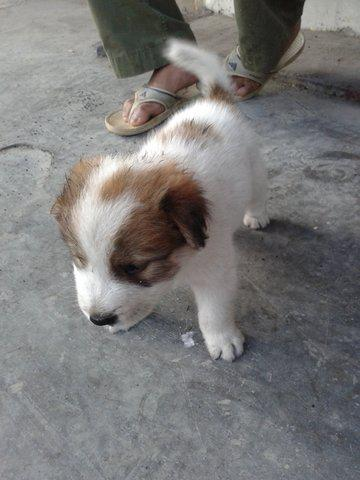

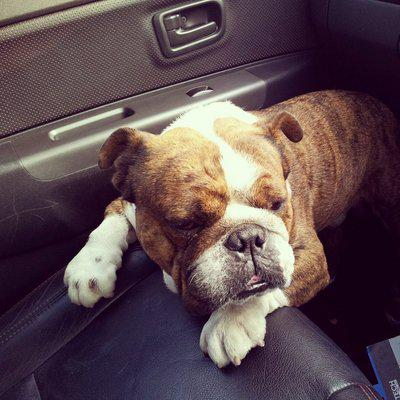

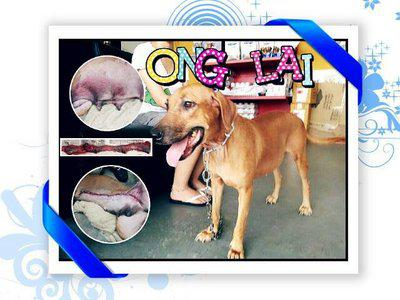

In [21]:
images_folder_path = "dataset/petfinder-adoption-prediction/train_images/"
for i in range(3):
    j = list(pets.index)[np.random.randint(low=0, high=pets.shape[0])]
    pre.get_image(images_folder_path, pets.filename[j])

# Resnet50

In [23]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([base_model, GlobalMaxPooling2D()])
model.summary()
# pickle.dump(model, open("image_reco.pkl", "wb"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
i = np.random.randint(low=0, high=pets.shape[0])
display(images.get_embedding(model, pets.filename.loc[i],images_folder_path))

array([ 1.5888616,  4.041352 ,  6.462575 , ..., 10.434416 ,  2.4965208,
       19.931583 ], dtype=float32)

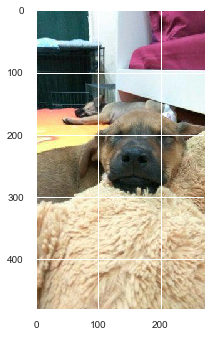

In [25]:
plt.imshow(cv2.cvtColor(images.load_image(pets, i, images_folder_path), cv2.COLOR_BGR2RGB));

In [28]:
map_embeddings_dogs = dogs.filename.swifter.apply(lambda img: images.get_embedding(model, img,images_folder_path))
data_embs_dogs = map_embeddings_dogs.apply(pd.Series)
map_embeddings_cats = cats.filename.swifter.apply(lambda img: images.get_embedding(model, img,images_folder_path))
data_embs_cats = map_embeddings_cats.apply(pd.Series)

In [29]:
to_include = ["type", "gender", "breed1", "breed2", "color1", "color2", "color3", "state"]
df_data_embs_dogs = pd.concat([data_embs_dogs, dogs[to_include]], axis=1)
df_data_embs_cats = pd.concat([data_embs_cats, cats[to_include]], axis=1)
df_cosine_dogs = 1-pairwise_distances(df_data_embs_dogs, metric='cosine')
df_cosine_cats = 1-pairwise_distances(df_data_embs_cats, metric='cosine')
pickle.dump(df_cosine_dogs, open("df_cosine_dogs_2.pkl", "wb"))
pickle.dump(df_cosine_cats, open("df_cosine_cats_2.pkl", "wb"))

In [37]:
df_cosine_cats

array([[1.        , 0.99998038, 0.99997832, ..., 0.99995082, 0.99995788,
        0.99997485],
       [0.99998038, 1.        , 0.99997826, ..., 0.99995598, 0.99996097,
        0.99997745],
       [0.99997832, 0.99997826, 1.        , ..., 0.99995623, 0.99995813,
        0.99997586],
       ...,
       [0.99995082, 0.99995598, 0.99995623, ..., 1.        , 0.99997595,
        0.99995235],
       [0.99995788, 0.99996097, 0.99995813, ..., 0.99997595, 1.        ,
        0.99995556],
       [0.99997485, 0.99997745, 0.99997586, ..., 0.99995235, 0.99995556,
        1.        ]])

# Test Model

Meet: 

Name: Ebay
Gender: Male
Breed: Labrador Retriever Mixed Breed
Color/s: Black Brown 
Fur Length: Medium
Vaccinated: No
Dewormed: No
Spayed or Neutered: No
Health: Healthy
No. of Pets in this Listing: 1
Adoption Fee: FREE
Location : Kedah
Description : Ebay is a healthy, active and playful dog. He is good to be kept as a guard dog and a good companion.


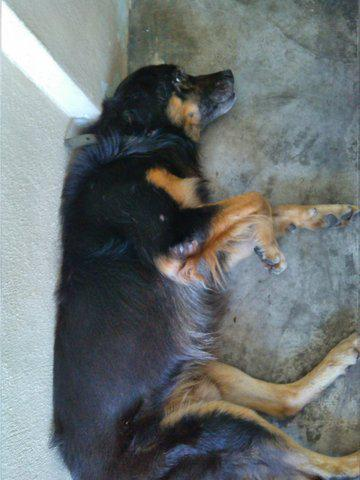




 Please check out these listings as well: 

Name: Orkim
Gender: Female
Breed: Doberman Pinscher Mixed Breed
Color/s: Black Brown 
Fur Length: Short
Vaccinated: Yes
Dewormed: Yes
Spayed or Neutered: Yes
Health: Healthy
No. of Pets in this Listing: 1
Adoption Fee: FREE
Location : Selangor
Description : Very good temperament and lovable dog looking for a home sweet home. Interested to adopt pls contact Amy 


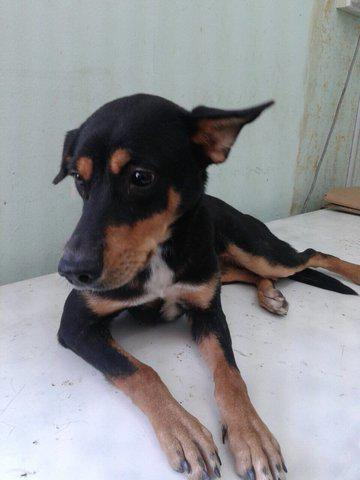

Note: Cosine Similarity = 0.9999842277663824 


Name: Shinney
Gender: Female
Breed: Doberman Pinscher Mixed Breed
Color/s: Black Yellow 
Fur Length: Short
Vaccinated: Yes
Dewormed: Yes
Spayed or Neutered: Yes
Health: Healthy
No. of Pets in this Listing: 1
Adoption Fee: FREE
Location : Selangor
Description : A nearby resident saw her 3 months ago with a few newborn puppies under a tree. Looking at her body condition which is healthy and well fed, the Vet believed that she must have been a missing dog. She take care of the puppies very well even though as a young mother. We rescue her and put her in a boarding vet clinic because the resident that she seek shelter in front of the house threaten to call dog catcher as he hates dogs.She is very tame and friendly but bark if strangers come near the house. She should make a good companion to the owner. No tying and caging for long hours except for precautionary purposes.


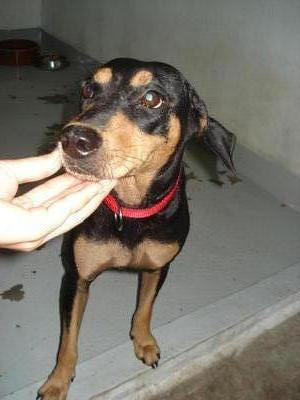

Note: Cosine Similarity = 0.9999842193505962 




In [84]:
r1 = np.random.randint(low=0, high=len(pets))
r2 = np.random.randint(low=1, high=4)
reco.get_similar_pet_listings(list(pets.index)[r1], r2)

In [96]:
print("Select pet index")

s1 = widgets.jslink(widgets.IntSlider(min=0,
                       max=len(pets),
                       step=1,
                       value=4,
                       description='pet index'))
s1.style.handle_color = 'lightblue'
s2 = widgets.jslink(widgets.IntSlider(min=1,
                       max=4,
                       step=1,
                       value=2,
                       description='similar listings'))
s2.style.handle_color = 'lightgreen'



display(interact_manual(reco.get_similar_pet_listings, i=s1, top=s2))

Select pet index


TypeError: jslink() missing 1 required positional argument: 'attr2'

In [50]:
# caption = widgets.Label(value="Select the pet to view:")
# dl = widgets.dlink((widgets.IntSlider(min=0,
#                              max=len(pets),
#                              step=1,
#                              value=2,
#                              description='Index'), 'value'), (widgets.IntSlider(
#                                  min=1,
#                                  max=4,
#                                  step=1,
#                                  value=2,
#                                  description='Top'), 'value'))
# display(caption)
# interact(reco.get_reco, i=idx, df=fixed(pets), top=top)